# Diffraction Spectrum of a Binary Grating

The mode-decomposition feature can also be applied to planewaves in homogeneous media with scalar permittivity/permeability (i.e., no anisotropy). This will be demonstrated in this example to compute the diffraction spectrum of a binary phase grating. To compute the diffraction spectrum for a finite-length structure, see Tutorials/Near to Far Field Spectra/Diffraction Spectrum of a Finite Binary Grating. 

The unit cell geometry of the grating is shown in the schematic below. The grating is periodic in the `y` direction with periodicity `gp` and has a rectangular profile of height `gh` and duty cycle `gdc`. The grating parameters are `gh=0.5` μm, `gdc=0.5`, and `gp=10 μm`. There is a semi-infinite substrate of thickness `dsub` adjacent to the grating. The substrate and grating are glass with a refractive index of 1.5. The surrounding is air/vacuum. Perfectly matched layers (PML) of thickness `dpml` are used in the $\pm x$ boundaries.

![geometry](https://meep.readthedocs.io/en/latest/images/grating.png)

## Transmittance Spectra for Planewave at Normal Incidence

A pulsed planewave with $E_z$ polarization spanning wavelengths of 0.4 to 0.6 μm is normally incident on the grating from the glass substrate. The eigenmode monitor is placed in the air region. We will use mode decomposition to compute the transmittance — the ratio of the power in the +x direction of the diffracted mode relative to that of the incident planewave — for the first ten diffraction orders. 

Two simulations are required: (1) an empty cell of homogeneous glass to obtain the incident power of the source, and (2) the grating structure to obtain the diffraction orders. At the end of the simulation, the wavelength, angle, and transmittance for each diffraction order are computed.

First, we'll import our standard libraries, along with the `fused_quartz` material from MEEP's material library.

In [1]:
# -*- coding: utf-8 -*-

import meep as mp
from meep.materials import fused_quartz
import math
import numpy as np
import matplotlib.pyplot as plt

Using MPI version 3.1, 1 processes


We first need to simulate the empty, homogenous glass (fuzed quartz).

-----------
Initializing structure...


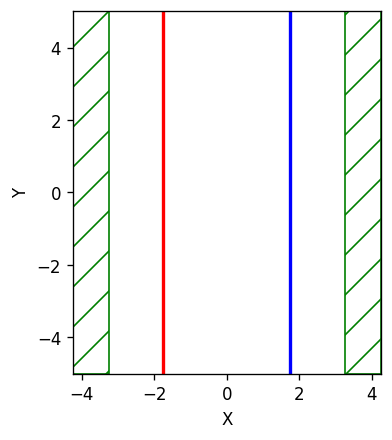

In [2]:
resolution = 50        # pixels/μm

dpml = 1.0             # PML thickness
dsub = 3.0             # substrate thickness
dpad = 3.0             # padding between grating and PML
gp = 10.0              # grating period
gh = 0.5               # grating height
gdc = 0.5              # grating duty cycle

sx = dpml+dsub+gh+dpad+dpml
sy = gp

cell_size = mp.Vector3(sx,sy,0)
pml_layers = [mp.PML(thickness=dpml,direction=mp.X)]

wvl_min = 0.4           # min wavelength
wvl_max = 0.6           # max wavelength
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width

src_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub)
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ez, center=src_pt, size=mp.Vector3(y=sy))]

k_point = mp.Vector3(0,0,0)

symmetries=[mp.Mirror(mp.Y)]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=k_point,
                    default_material=fused_quartz,
                    sources=sources,
                    symmetries=symmetries)

nfreq = 21
mon_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad)
flux_mon = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy)))

f = plt.figure(dpi=120)
sim.plot2D(ax=f.gca())
plt.show()

Now, we'll run the simulation and record the fields.

In [3]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

field decay(t = 50.01): 0.11139427530016409 / 0.11139427530016409 = 1.0
field decay(t = 100.01): 1.824305440068526e-15 / 0.11139427530016409 = 1.637701250941967e-14
run 0 finished at t = 100.01 (10001 timesteps)


Next, we'll simulate the actual grating.

-----------
Initializing structure...
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


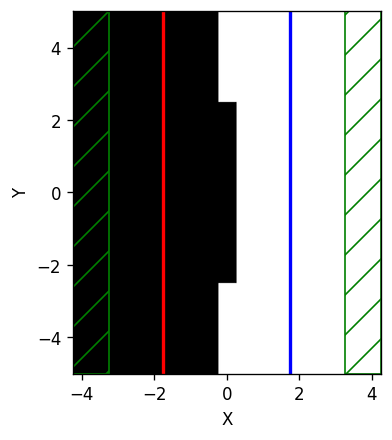

In [4]:
input_flux = mp.get_fluxes(flux_mon)

sim.reset_meep()

geometry = [mp.Block(material=fused_quartz, size=mp.Vector3(dpml+dsub,mp.inf,mp.inf), center=mp.Vector3(-0.5*sx+0.5*(dpml+dsub))),
            mp.Block(material=fused_quartz, size=mp.Vector3(gh,gdc*gp,mp.inf), center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh))]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    k_point=k_point,
                    sources=sources,
                    symmetries=symmetries)

mode_mon = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy)))

f2 = plt.figure(dpi=120)
sim.plot2D(ax=f2.gca())
plt.show()

In [5]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

field decay(t = 50.01): 0.1082498119209954 / 0.1082498119209954 = 1.0
field decay(t = 100.01): 7.512926070352665e-06 / 0.1082498119209954 = 6.940359467632024e-05
field decay(t = 150.02): 6.732414916367269e-06 / 0.1082498119209954 = 6.219331744687766e-05
field decay(t = 200.03): 2.3712635292765586e-06 / 0.1082498119209954 = 2.1905474819736332e-05
field decay(t = 250.04): 9.494875348809632e-07 / 0.1082498119209954 = 8.771262675023706e-06
field decay(t = 300.04): 3.8220269083178343e-07 / 0.1082498119209954 = 3.530746927400933e-06
field decay(t = 350.05): 1.5689447663324306e-07 / 0.1082498119209954 = 1.4493741268368232e-06
field decay(t = 400.06): 6.492618040375044e-08 / 0.1082498119209954 = 5.997809996301509e-07
field decay(t = 450.07): 2.9338161615346314e-08 / 0.1082498119209954 = 2.710227490903943e-07
field decay(t = 500.08): 1.115652431764312e-08 / 0.1082498119209954 = 1.0306275936798441e-07
field decay(t = 550.08): 4.421515879496221e-09 / 0.1082498119209954 = 4.084548324872104e-08
fie

In [6]:
freqs = mp.get_eigenmode_freqs(mode_mon)

nmode = 10
res = sim.get_eigenmode_coefficients(mode_mon, range(1,nmode+1), eig_parity=mp.ODD_Z+mp.EVEN_Y)
coeffs = res.alpha
kdom = res.kdom

mode_wvl = []
mode_angle = []
mode_tran = []

for nm in range(nmode):
  for nf in range(nfreq):
    mode_wvl.append(1/freqs[nf])
    mode_angle.append(math.degrees(math.acos(kdom[nm*nfreq+nf].x/freqs[nf])))
    tran = abs(coeffs[nm,nf,0])**2/input_flux[nf]
    mode_tran.append(0.5*tran if nm != 0 else tran)
    print("grating{}:, {:.5f}, {:.2f}, {:.8f}".format(nm,mode_wvl[-1],mode_angle[-1],mode_tran[-1]))

tran_max = round(max(mode_tran),1)

grating0:, 0.60000, 0.00, 0.12884455
grating0:, 0.58537, 0.00, 0.10877453
grating0:, 0.57143, 0.00, 0.09019427
grating0:, 0.55814, 0.00, 0.07312453
grating0:, 0.54545, 0.00, 0.05778349
grating0:, 0.53333, 0.00, 0.04394176
grating0:, 0.52174, 0.00, 0.03203070
grating0:, 0.51064, 0.00, 0.02188719
grating0:, 0.50000, 0.00, 0.01363406
grating0:, 0.48980, 0.00, 0.00741318
grating0:, 0.48000, 0.00, 0.00318863
grating0:, 0.47059, 0.00, 0.00103727
grating0:, 0.46154, 0.00, 0.00101454
grating0:, 0.45283, 0.00, 0.00313542
grating0:, 0.44444, 0.00, 0.00745115
grating0:, 0.43636, 0.00, 0.01396620
grating0:, 0.42857, 0.00, 0.02252241
grating0:, 0.42105, 0.00, 0.03341204
grating0:, 0.41379, 0.00, 0.04635643
grating0:, 0.40678, 0.00, 0.06143255
grating0:, 0.40000, 0.00, 0.07872147
grating1:, 0.60000, 3.44, 0.34156387
grating1:, 0.58537, 3.36, 0.34944613
grating1:, 0.57143, 3.28, 0.35680089
grating1:, 0.55814, 3.20, 0.36346042
grating1:, 0.54545, 3.13, 0.36942481
grating1:, 0.53333, 3.06, 0.37469297
g

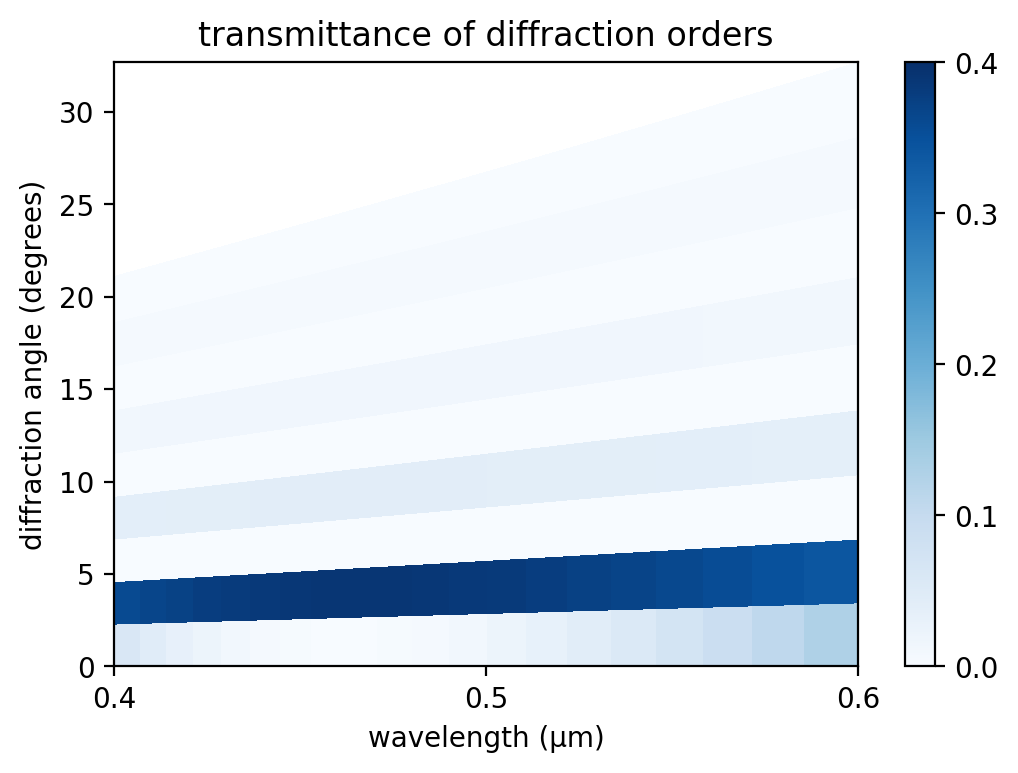

In [7]:
plt.figure(dpi=200)
plt.pcolormesh(np.reshape(mode_wvl,(nmode,nfreq)),
               np.reshape(mode_angle,(nmode,nfreq)),
               np.reshape(mode_tran,(nmode,nfreq)),
               cmap='Blues',
               shading='flat',
               vmin=0,
               vmax=tran_max)
plt.axis([min(mode_wvl), max(mode_wvl), min(mode_angle), max(mode_angle)])
plt.xlabel("wavelength (μm)")
plt.ylabel("diffraction angle (degrees)")
plt.xticks([t for t in np.linspace(wvl_min,wvl_max,3)])
plt.yticks([t for t in range(0,35,5)])
plt.title("transmittance of diffraction orders")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0,tran_max+0.1,0.1)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.arange(0,tran_max+0.1,0.1)])